# WEP Timing Tests

Owner: **Bryce Kalmbach** ([@jbkalmbach](https://github.com/lsst-ts/ts_analysis_notebooks/issues/new?body=@jbkalmbach))
<br>Last Verified to Run: **2022-06-06**
<br>Software Versions:
  - `lsst_distrib`: **w_2022_22**

## Notebook Objective

The goal of this notebook is to calculate the time various tasks in the AOS Wavefront Estimation Pipeline take and to keep track of how they have changed over time.

## Logistics

The data used to gather timing information is stored on NCSA and this notebook has been created and tested on the Rubin Science Platform at https://lsst-rsp-stable.ncsa.illinois.edu/nb.

The data used for timing was created for a low density field and a high density field using three different versions of the `ts_wep` pipeline:

1. `ts_wep` v2.3.6: This version is an older baseline version before optimizations in the loop structure of the Zernike estimation code.
2. `ts_wep` v2.4.0 w/ `EstimateZernikesCwfsTask` (Old Pipeline): This version is a newer version with code optimizations within the Zernike estimation code but uses a Gen 3 task `EstimateZernikesCwfsTask` that combines the postage stamp creation of donut sources and the Zernike estimation into a single task. Since we need to load extra and intra-focal images together when creating the donut postage stamps we cannot parallelize across the 4 pairs of donut sensors as the DM pipeline is not set up to parallelize across pairs of detectors only across individual detectors.
3. `ts_wep` v2.4.0 w/ `CutOutDonutStampsCwfsTask` and `CalcZernikesTask`: This version has the optimizations within the Zernike estimation code as well as breaking the donut postage stamp creation and Zernike calculation steps into two separate Gen 3 tasks. The `CutOutDonutsCwfsTask` cuts out the donut postage stamps from the extra and intra-focal pairs of stamps and then saves these all under the data ID of the extrafocal detector. Therefore when calculating the Zernikes for each pair of wavefront detectors we only need to call the extra-focal detectors and the DM pipeline can parallelize the calculation across the data associated with the 4 extra-focal sensors in separate tasks using `CalcZernikesTask`.

Sample pipeline commands used to run on `lsst-devl` and generate the data are below.

Sample pipeline command used for this notebook (low density field): 
```
pipetask run -b /project/aos/data_repos/aosTestDataRepo -i refcats/DM-28636,LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run cwfs_test_052022_new_pipeline_low_dens -p /home/brycek/jhome/notebooks/Commissioning/aos/ts_analysis_notebooks/aos/aos_milestones/lsstCwfsPipelineNew.yaml -d "exposure IN (4021123110021) and detector IN (191, 192, 195, 196, 199, 200, 203, 204)" -j 4
```

Sample pipeline command used for this notebook (high density field): 
```
pipetask run -b /project/aos/data_repos/aosTestDataRepo -i refcats/DM-28636,LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run cwfs_test_052022_new_pipeline_high_dens -p /home/brycek/jhome/notebooks/Commissioning/aos/ts_analysis_notebooks/aos/aos_milestones/lsstCwfsPipelineNew.yaml -d "exposure IN (4021123106040) and detector IN (191, 192, 195, 196, 199, 200, 203, 204)" -j 4
```

In [1]:
# Some basic imports
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# This allows us to run command line tasks from inside the notebook easier
from lsst.ts.wep.Utility import runProgram, writePipetaskCmd, writeCleanUpRepoCmd

# Location of ts_wep
ts_wep_dir = os.environ['TS_WEP_DIR']

# Import Gen 3 Butler
from lsst.daf import butler as dafButler

# Enable markdown within code cell
from IPython.display import Markdown as md

## Prepare butler and dataIds

Here we load the butler that stores AOS test data on `lsst-devl` and generate the data IDs for the low and high density fields.

In [2]:
# First specify the repository location
repoDir = '/project/aos/data_repos/aosTestDataRepo'

In [3]:
butler = dafButler.Butler(repoDir)
registry = butler.registry

The 3 different pipelines were run for both low and high density fields and are the six `cwfs_test_052022` collections below.

In [4]:
list(registry.queryCollections())

['refcats/DM-28636',
 'LSSTCam/raw/all',
 'LSSTCam/calib',
 'LSSTCam/calib/unbounded',
 'w_2022_06',
 'cwfs_test_052022_orig_pipeline_high_dens',
 'cwfs_test_052022_new_pipeline_high_dens',
 'cwfs_test_052022_orig_pipeline_high_dens_pre_optimize',
 'cwfs_test_052022_new_pipeline_low_dens',
 'cwfs_test_052022_orig_pipeline_low_dens',
 'cwfs_test_052022_orig_pipeline_low_dens_pre_optimize']

In [5]:
dataIdExtra_lowDens = {'instrument': 'LSSTCam', 'detector': 191, 'exposure': 4021123110021, 'visit': 4021123110021}
dataIdIntra_lowDens = {'instrument': 'LSSTCam', 'detector': 192, 'exposure': 4021123110021, 'visit': 4021123110021}

In [6]:
dataIdExtra_highDens = {'instrument': 'LSSTCam', 'detector': 191, 'exposure': 4021123106040, 'visit': 4021123106040}
dataIdIntra_highDens = {'instrument': 'LSSTCam', 'detector': 192, 'exposure': 4021123106040, 'visit': 4021123106040}

## Timing Tests

We get the timing information for each pipeline task by gathering the data from the associated metadata stored in the butler repository.

There are three steps to the wavefront estimation pipeline that are broken down into three or four pipeline tasks depending on the version used. We go through each of them here in order that they are run.

### ISR

We currently run ISR with the following configuration:

```
doBias: False
doVariance: False
doLinearize: False
doCrosstalk: False
doDefect: False
doNanMasking: False
doInterpolate: False
doBrighterFatter: False
doDark: False
doFlat: False
doApplyGains: True
doFringe: False
doOverscan: True
```

#### Low Density Field

Only check the timing on this for one of the high density runs since this should be roughly the same for all pipelines.

In [7]:
runName = 'cwfs_test_052022_orig_pipeline_low_dens'

isrTimes_lowDens = []
for detectorNum in [191, 195, 199, 203]:
    dataIdExtra_lowDens['detector'] = detectorNum
    taskLog = butler.get('isr_log', dataId=dataIdExtra_lowDens, collections=[runName])
    taskMessage = taskLog[-1].message
    taskTime = float(taskMessage.split('took')[1].split(' ')[1])
    isrTimes_lowDens.append(taskTime)
    
for detectorNum in [192, 196, 200, 204]:
    dataIdIntra_lowDens['detector'] = detectorNum
    taskLog = butler.get('isr_log', dataId=dataIdIntra_lowDens, collections=[runName])
    taskMessage = taskLog[-1].message
    taskTime = float(taskMessage.split('took')[1].split(' ')[1])
    isrTimes_lowDens.append(taskTime)

In [8]:
isrTimes_lowDens

[4.956, 7.856, 4.811, 4.552, 6.689, 5.637, 4.531, 4.59]

In [9]:
isrTimes_lowDens_avg = np.mean(isrTimes_lowDens)
isrTimes_lowDens_max = np.max(isrTimes_lowDens)

In [10]:
md(
    f"Average ISR time for detector in low density field: {isrTimes_lowDens_avg} seconds. <br>" +
    f"Max ISR time for detector in low density field: {isrTimes_lowDens_max} seconds."
)

Average ISR time for detector in low density field: 5.45275 seconds. <br>Max ISR time for detector in low density field: 7.856 seconds.

#### High Density Field

Only check the timing on this for one of the high density runs since this should be roughly the same for all pipelines.

In [11]:
runName = 'cwfs_test_052022_orig_pipeline_high_dens'

isrTimes_highDens = []
for detectorNum in [191, 195, 199, 203]:
    dataIdExtra_highDens['detector'] = detectorNum
    taskLog = butler.get('isr_log', dataId=dataIdExtra_highDens, collections=[runName])
    taskMessage = taskLog[-1].message
    taskTime = float(taskMessage.split('took')[1].split(' ')[1])
    isrTimes_highDens.append(taskTime)
    
for detectorNum in [192, 196, 200, 204]:
    dataIdIntra_highDens['detector'] = detectorNum
    taskLog = butler.get('isr_log', dataId=dataIdIntra_highDens, collections=[runName])
    taskMessage = taskLog[-1].message
    taskTime = float(taskMessage.split('took')[1].split(' ')[1])
    isrTimes_highDens.append(taskTime)

In [12]:
isrTimes_highDens

[4.568, 5.757, 8.1, 4.702, 4.696, 4.544, 4.406, 6.847]

In [13]:
isrTimes_highDens_avg = np.mean(isrTimes_highDens)
isrTimes_highDens_max = np.max(isrTimes_highDens)

In [14]:
md(
    f"Average ISR time for detector in high density field: {isrTimes_highDens_avg} seconds. <br>" +
    f"Max ISR time for detector in high density field: {isrTimes_highDens_max} seconds."
)

Average ISR time for detector in high density field: 5.4525 seconds. <br>Max ISR time for detector in high density field: 8.1 seconds.

### Generate Donut Catalog

This step loads the reference catalog sources that fall on the detector and then runs the donut source selection code. It then saves the resulting donut catalog to the butler.
Once again this step should be the same for all pipelines but this will differ in the low vs. high density fields based upon the number of sources the selector needs to evalulate.

#### Low density field

In [15]:
runName = 'cwfs_test_052022_orig_pipeline_low_dens'

generateDonutCatalogTimes_lowDens = []
numCatalogObjects_lowDens = []
for detectorNum in [191, 195, 199, 203]:
    dataIdExtra_lowDens['detector'] = detectorNum
    taskLog = butler.get('generateDonutCatalogWcsTask_log', dataId=dataIdExtra_lowDens, collections=[runName])
    taskMessage = taskLog[-1].message
    taskTime = float(taskMessage.split('took')[1].split(' ')[1])
    generateDonutCatalogTimes_lowDens.append(taskTime)
    taskNumObj = int(taskLog[-4].message.split(' ')[1])
    numCatalogObjects_lowDens.append(taskNumObj)
    
for detectorNum in [192, 196, 200, 204]:
    dataIdIntra_lowDens['detector'] = detectorNum
    taskLog = butler.get('generateDonutCatalogWcsTask_log', dataId=dataIdIntra_lowDens, collections=[runName])
    taskMessage = taskLog[-1].message
    taskTime = float(taskMessage.split('took')[1].split(' ')[1])
    generateDonutCatalogTimes_lowDens.append(taskTime)
    taskNumObj = int(taskLog[-4].message.split(' ')[1])
    numCatalogObjects_lowDens.append(taskNumObj)

In [16]:
donutCatalogTime_lowDens_max = max(generateDonutCatalogTimes_lowDens)
donutCatalogTime_lowDens_avg = np.mean(generateDonutCatalogTimes_lowDens)

In [17]:
numCatalogObjects_lowDens_max = max(numCatalogObjects_lowDens)
numCatalogObjects_lowDens_avg = np.mean(numCatalogObjects_lowDens)

In [18]:
md(
    f"Average donut catalog creation time for detector in low density field is {donutCatalogTime_lowDens_avg:.4f} seconds " +
    f"with an average of {numCatalogObjects_lowDens_avg} reference catalog sources on each chip. <br>" +
    f"Max donut catalog creation time for detector in low density field is {donutCatalogTime_lowDens_max:.4f} seconds " +
    f"with {numCatalogObjects_lowDens_max} reference catalog sources on the chip. <br>" 
)

Average donut catalog creation time for detector in low density field is 1.3124 seconds with an average of 1266.25 reference catalog sources on each chip. <br>Max donut catalog creation time for detector in low density field is 1.5340 seconds with 1703 reference catalog sources on the chip. <br>

#### High density field

In [19]:
runName = 'cwfs_test_052022_orig_pipeline_high_dens'

generateDonutCatalogTimes_highDens = []
numCatalogObjects_highDens = []
for detectorNum in [191, 195, 199, 203]:
    dataIdExtra_highDens['detector'] = detectorNum
    taskLog = butler.get('generateDonutCatalogWcsTask_log', dataId=dataIdExtra_highDens, collections=[runName])
    taskMessage = taskLog[-1].message
    taskTime = float(taskMessage.split('took')[1].split(' ')[1])
    generateDonutCatalogTimes_highDens.append(taskTime)
    taskNumObj = int(taskLog[-4].message.split(' ')[1])
    numCatalogObjects_highDens.append(taskNumObj)

for detectorNum in [192, 196, 200, 204]:
    dataIdIntra_highDens['detector'] = detectorNum
    taskLog = butler.get('generateDonutCatalogWcsTask_log', dataId=dataIdIntra_highDens, collections=[runName])
    taskMessage = taskLog[-1].message
    taskTime = float(taskMessage.split('took')[1].split(' ')[1])
    generateDonutCatalogTimes_highDens.append(taskTime)
    taskNumObj = int(taskLog[-4].message.split(' ')[1])
    numCatalogObjects_highDens.append(taskNumObj)

In [20]:
donutCatalogTime_highDens_max = max(generateDonutCatalogTimes_highDens)
donutCatalogTime_highDens_avg = np.mean(generateDonutCatalogTimes_highDens)

In [21]:
numCatalogObjects_highDens_max = max(numCatalogObjects_highDens)
numCatalogObjects_highDens_avg = np.mean(numCatalogObjects_highDens)

In [22]:
md(
    f"Average donut catalog creation time for detector in high density field is {donutCatalogTime_highDens_avg:.4f} seconds " +
    f"with an average of {numCatalogObjects_highDens_avg} reference catalog sources on each chip. <br>" +
    f"Max donut catalog creation time for detector in high density field is {donutCatalogTime_highDens_max:.4f} seconds " +
    f"with {numCatalogObjects_highDens_max} reference catalog sources on the chip. <br>" 
)

Average donut catalog creation time for detector in high density field is 7.1098 seconds with an average of 11018.0 reference catalog sources on each chip. <br>Max donut catalog creation time for detector in high density field is 11.6460 seconds with 13374 reference catalog sources on the chip. <br>

### Estimate Zernikes

Here is where the pipelines start to diverge. In the first two instances there is only one task that performs both the donut postage stamp creation and the Zernike estimation. In the final instance (v2.4.0 w/ New Pipeline) this is split in two tasks.

In this section we will first load all the data and then compare the results at the end.

#### `ts_wep` v2.3.6 (Pre-Optimize)

##### Low Density

In [23]:
runName = 'cwfs_test_052022_orig_pipeline_low_dens_pre_optimize'

taskLog = butler.get('estimateZernikesCwfsTask_log', dataId=dataIdExtra_lowDens, collections=[runName])
taskMessage = taskLog[0].message
origPipelineTime_preOptimize_lowDens = float(taskMessage.split('took')[1].split(' ')[1])

##### High Density

In [24]:
runName = 'cwfs_test_052022_orig_pipeline_high_dens_pre_optimize'

taskLog = butler.get('estimateZernikesCwfsTask_log', dataId=dataIdExtra_highDens, collections=[runName])
taskMessage = taskLog[0].message
origPipelineTime_preOptimize_highDens = float(taskMessage.split('took')[1].split(' ')[1])

#### `ts_wep` v2.4.0 w/ Original Pipeline

##### Low Density

In [25]:
runName = 'cwfs_test_052022_orig_pipeline_low_dens'

taskLog = butler.get('estimateZernikesCwfsTask_log', dataId=dataIdExtra_lowDens, collections=[runName])
taskMessage = taskLog[0].message
origPipelineTime_lowDens = float(taskMessage.split('took')[1].split(' ')[1])

##### High Density

In [26]:
runName = 'cwfs_test_052022_orig_pipeline_high_dens'

taskLog = butler.get('estimateZernikesCwfsTask_log', dataId=dataIdExtra_highDens, collections=[runName])
taskMessage = taskLog[0].message
origPipelineTime_highDens = float(taskMessage.split('took')[1].split(' ')[1])

#### `ts_wep` v2.4.0 w/ Original Pipeline

#### Low Density

In [27]:
runName = 'cwfs_test_052022_new_pipeline_low_dens'

taskLog = butler.get('cutOutDonutsCwfsTask_log', dataId=dataIdExtra_lowDens, collections=[runName])
taskMessage = taskLog[0].message
cutOutDonutsTaskTime_lowDens = float(taskMessage.split('took')[1].split(' ')[1])

We can also look at how many donuts we used in each detector.

In [28]:
runName = 'cwfs_test_052022_new_pipeline_low_dens'

calcZernikesTimes_lowDens = []
numDonutsCalc_lowDens = 0
maxDonutsCalc_lowDens = 0
for detectorNum in [191, 195, 199, 203]:
    dataIdExtra_lowDens['detector'] = detectorNum
    metadata = butler.get('calcZernikesTask_metadata', dataId=dataIdExtra_lowDens, collections=[runName])
    print(metadata['calcZernikesTask:combineZernikes'])
    taskLog = butler.get('calcZernikesTask_log', dataId=dataIdExtra_lowDens, collections=[runName])
    taskMessage = taskLog[0].message
    taskTime = float(taskMessage.split('took')[1].split(' ')[1])
    calcZernikesTimes_lowDens.append(taskTime)
    numDonutsCalc_lowDens += metadata['calcZernikesTask:combineZernikes']['numDonutsTotal']
    if metadata['calcZernikesTask:combineZernikes']['numDonutsTotal'] > maxDonutsCalc_lowDens:
        maxDonutsCalc_lowDens = metadata['calcZernikesTask:combineZernikes']['numDonutsTotal']

scalars={'numDonutsTotal': 3, 'numDonutsUsed': 2, 'numDonutsRejected': 1} arrays={'combineZernikesFlags': [1, 0, 0]} metadata={}
scalars={'numDonutsTotal': 4, 'numDonutsUsed': 3, 'numDonutsRejected': 1} arrays={'combineZernikesFlags': [1, 0, 0, 0]} metadata={}
scalars={'numDonutsTotal': 3, 'numDonutsUsed': 2, 'numDonutsRejected': 1} arrays={'combineZernikesFlags': [1, 0, 0]} metadata={}
scalars={'numDonutsTotal': 2, 'numDonutsUsed': 2, 'numDonutsRejected': 0} arrays={'combineZernikesFlags': [0, 0]} metadata={}


In [29]:
calcZernikesTaskTime_lowDens_max = max(calcZernikesTimes_lowDens)
calcZernikesTaskTime_lowDens_avg = np.mean(calcZernikesTimes_lowDens)

In [30]:
newPipelineTime_lowDens_max = cutOutDonutsTaskTime_lowDens + calcZernikesTaskTime_lowDens_max
newPipelineTime_lowDens_avg = cutOutDonutsTaskTime_lowDens + calcZernikesTaskTime_lowDens_avg

#### High Density

In [31]:
runName = 'cwfs_test_052022_new_pipeline_high_dens'

taskLog = butler.get('cutOutDonutsCwfsTask_log', dataId=dataIdExtra_highDens, collections=[runName])
taskMessage = taskLog[0].message
cutOutDonutsTaskTime_highDens = float(taskMessage.split('took')[1].split(' ')[1])

Once again we can look at how many donuts we used in each detector.

In [32]:
runName = 'cwfs_test_052022_new_pipeline_high_dens'

calcZernikesTimes_highDens = []
numDonutsCalc_highDens = 0
maxDonutsCalc_highDens = 0
for detectorNum in [191, 195, 199, 203]:
    dataIdExtra_highDens['detector'] = detectorNum
    metadata = butler.get('calcZernikesTask_metadata', dataId=dataIdExtra_highDens, collections=[runName])
    print(metadata['calcZernikesTask:combineZernikes'])
    taskLog = butler.get('calcZernikesTask_log', dataId=dataIdExtra_highDens, collections=[runName])
    taskMessage = taskLog[0].message
    taskTime = float(taskMessage.split('took')[1].split(' ')[1])
    calcZernikesTimes_highDens.append(taskTime)
    numDonutsCalc_highDens += metadata['calcZernikesTask:combineZernikes']['numDonutsTotal']
    if metadata['calcZernikesTask:combineZernikes']['numDonutsTotal'] > maxDonutsCalc_highDens:
        maxDonutsCalc_highDens = metadata['calcZernikesTask:combineZernikes']['numDonutsTotal']

scalars={'numDonutsTotal': 14, 'numDonutsUsed': 12, 'numDonutsRejected': 2} arrays={'combineZernikesFlags': [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]} metadata={}
scalars={'numDonutsTotal': 12, 'numDonutsUsed': 7, 'numDonutsRejected': 5} arrays={'combineZernikesFlags': [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1]} metadata={}
scalars={'numDonutsTotal': 14, 'numDonutsUsed': 12, 'numDonutsRejected': 2} arrays={'combineZernikesFlags': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0]} metadata={}
scalars={'numDonutsTotal': 9, 'numDonutsUsed': 7, 'numDonutsRejected': 2} arrays={'combineZernikesFlags': [0, 0, 0, 0, 0, 1, 0, 0, 1]} metadata={}


In [33]:
calcZernikesTaskTime_highDens_max = max(calcZernikesTimes_highDens)
calcZernikesTaskTime_highDens_avg = np.mean(calcZernikesTimes_highDens)

In [34]:
newPipelineTime_highDens_max = cutOutDonutsTaskTime_highDens + calcZernikesTaskTime_highDens_max
newPipelineTime_highDens_avg = cutOutDonutsTaskTime_highDens + calcZernikesTaskTime_highDens_avg

### Results

#### Low Density

In [35]:
md(
    f'For field with {numDonutsCalc_lowDens} total donuts across 4 pairs of wavefront sensors with a max of {maxDonutsCalc_lowDens} on a detector: <br>' +
    f'Pre-optimization pipeline time = {origPipelineTime_preOptimize_lowDens} s. <br>' + 
    f'Optimized original pipeline time = {origPipelineTime_lowDens} s. <br>' +
    f'New pipeline time (Avg/Max) = {newPipelineTime_lowDens_avg} s. / {newPipelineTime_lowDens_max} s.'
)

For field with 12 total donuts across 4 pairs of wavefront sensors with a max of 4 on a detector: <br>Pre-optimization pipeline time = 60.73 s. <br>Optimized original pipeline time = 24.707 s. <br>New pipeline time (Avg/Max) = 13.05725 s. / 14.522 s.

#### High Density

In [36]:
md(
    f'For field with {numDonutsCalc_highDens} total donuts across 4 pairs of wavefront sensors with a max of {maxDonutsCalc_highDens} on a detector: <br>' +
    f'Pre-optimization pipeline time = {origPipelineTime_preOptimize_highDens} s.<br>' + 
    f'Optimized original pipeline time = {origPipelineTime_highDens} s.<br>' +
    f'New pipeline time (Avg/Max) = {newPipelineTime_highDens_avg} s. / {newPipelineTime_highDens_max} s.'
)

For field with 49 total donuts across 4 pairs of wavefront sensors with a max of 14 on a detector: <br>Pre-optimization pipeline time = 230.743 s.<br>Optimized original pipeline time = 83.773 s.<br>New pipeline time (Avg/Max) = 31.1085 s. / 33.944 s.

## Summary

Text(0.5, 1.0, 'Cut out donuts and calculate Zernikes tasks. LSST-DEVL w/ 4 processes.')

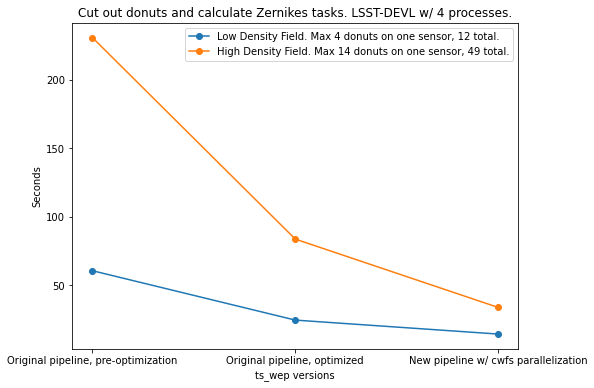

In [37]:
%matplotlib inline
fig = plt.figure(figsize=(8, 6))
plt.plot(np.arange(3), [origPipelineTime_preOptimize_lowDens,
                        origPipelineTime_lowDens,
                        newPipelineTime_lowDens_max], '-o', label='Low Density Field. Max 4 donuts on one sensor, 12 total.')
plt.plot(np.arange(3), [origPipelineTime_preOptimize_highDens,
                        origPipelineTime_highDens,
                        newPipelineTime_highDens_max], '-o', label='High Density Field. Max 14 donuts on one sensor, 49 total.')
plt.legend()
plt.ylabel('Seconds')
plt.xlabel('ts_wep versions')
plt.xticks([0, 1, 2], ['Original pipeline, pre-optimization', 'Original pipeline, optimized', 'New pipeline w/ cwfs parallelization'])
plt.title('Cut out donuts and calculate Zernikes tasks. LSST-DEVL w/ 4 processes.')

In [38]:
labels = np.array(['Low Density', 'High Density'])
isr = np.array([isrTimes_lowDens_avg, isrTimes_lowDens_avg])
donutCat = np.array([donutCatalogTime_lowDens_avg, donutCatalogTime_highDens_avg])
cutOuts = [cutOutDonutsTaskTime_lowDens, cutOutDonutsTaskTime_highDens]
calcZerns = [calcZernikesTaskTime_lowDens_max, calcZernikesTaskTime_highDens_max]
width = 0.8

Text(0.5, 1.0, 'Timing of WEP Tasks (ts_wep v2.4.0 w/ new pipeline)')

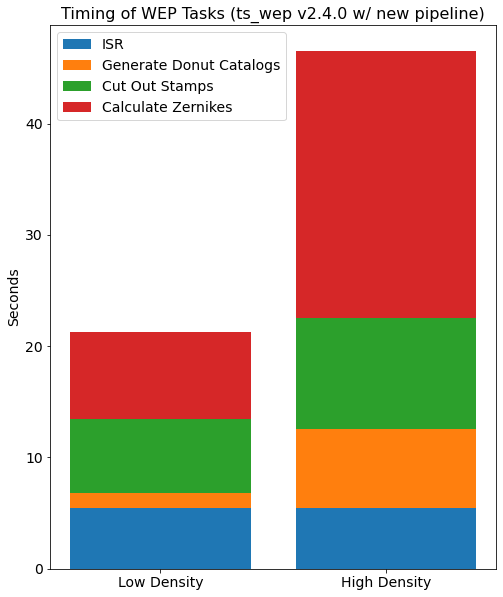

In [39]:
fig, ax = plt.subplots(figsize=(8, 10))
ax.bar(labels, isr, width, label='ISR')
ax.bar(labels, donutCat, width, label='Generate Donut Catalogs', bottom=isr)
ax.bar(labels, cutOuts, width, label='Cut Out Stamps', bottom=donutCat+isr)
ax.bar(labels, calcZerns, width, label='Calculate Zernikes', bottom=cutOuts+donutCat+isr)
plt.legend(fontsize=14)
plt.ylabel('Seconds', size=14)
ax.tick_params(labelsize=14)
plt.title('Timing of WEP Tasks (ts_wep v2.4.0 w/ new pipeline)', size=16)